**This is from the "Natural Language Processing with Disaster Tweets" kaggle competition: https://www.kaggle.com/c/nlp-getting-started**

**The aim is to try to classify tweets to determine whether they relate to real disasters or not**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from urllib.parse import unquote
import spacy
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)
nlp = spacy.load("en_core_web_lg")
STOPWORDS = stopwords.words("english")

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Load in the data

In [2]:
df = pd.read_csv("~/train.csv", index_col="id")
df

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [3]:
val = pd.read_csv("~/test.csv", index_col="id")
val

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...


# Explore and clean the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


keyword       61
location    2533
text           0
target         0
dtype: int64


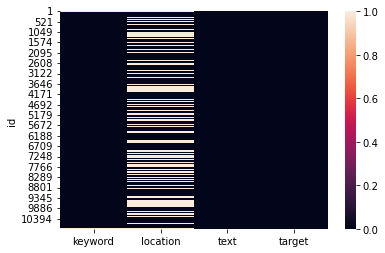

In [5]:
# Look for missing data
sns.heatmap(df.isnull())
print(df.isnull().sum())

**From the above, it looks like we're missing a few keywords and a signficant number of locations**

In [6]:
df[~df["location"].isnull()]["location"].value_counts()

USA                       104
New York                   71
United States              50
London                     45
Canada                     29
                         ... 
Eagle Mountain, Texas       1
Anywhere Safe               1
Stay Tuned ;)               1
San Juan, Puerto Rico       1
Brum/Lestah                 1
Name: location, Length: 3341, dtype: int64

In [7]:
df["location"].nunique()

3341

**It also appears that there are far too many locations to really be useful - let's just drop location from the mix in the future**

In [8]:
df[~df["keyword"].isnull()]["keyword"].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

**It looks like our keywords are also URL encoded - we should remember to clean those up before performing processing**

In [9]:
df

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


**We could try to impute a cleaner country from the location, and if it doesn't find one, maybe the text? We can use named entity recognition for this:**

In [10]:
print("LOC: ", spacy.explain("LOC"))
print("GPE: ", spacy.explain("GPE"))

LOC:  Non-GPE locations, mountain ranges, bodies of water
GPE:  Countries, cities, states


In [11]:
def impute_location(doc, rev=False):
    """
    Tries to extract a location from the document.
    Implemented reversal of string to try get most macroscopic entity first (e.g. AU from 42 Wallaby Way, Sydney, AU)
    """
    ents = doc.ents
    if rev:
        ents = reversed(ents)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            return ent.text
    return np.nan

**Lets test the above to see just how effective it would be**

In [12]:
total_len = len(df)
loc_missing_bef = df["location"].isnull().sum()
loc_missing_aft = df[df["location"].isnull()]["text"].parallel_apply(lambda x: impute_location(nlp(x))).isnull().sum()
print(f"Imputed locations from text. Previously had {loc_missing_bef}/{total_len} ({100*loc_missing_bef/total_len:.1f}%) missing locations - now have {loc_missing_aft}/{total_len} ({100*loc_missing_aft/total_len:.1f}%), an improvement of {loc_missing_bef-loc_missing_aft} rows ({100*(loc_missing_bef-loc_missing_aft)/total_len:.1f}% of total df)")

Imputed locations from text. Previously had 2533/7613 (33.3%) missing locations - now have 2093/7613 (27.5%), an improvement of 440 rows (5.8% of total df)


Unfortunately there's not really much of an improvement here to warrant including it in the dataset. Let's just drop it

**We can also try to do something similar with the keyword, likely with more success given there are less missing values**

In [13]:
import re
kw_pat = re.compile(r"#(\w+)", flags=re.IGNORECASE)

def impute_keyword(doc):
    """
    Look for matches in the doc text starting in a hashtag.
    If one is found, return it's vector. If more than one are found, return the pairwise mean of the vectors across their axes. If no hashtag is found, return NaN to be filtered out later
    """
    matches = kw_pat.findall(doc.text)
    if matches:
        if len(matches) == 1:
            return nlp(unquote(matches[0])).vector
        else:
            return np.mean([nlp(unquote(m)).vector for m in matches], axis=0)
    else:
        return []

**We can now build our preprocessing pipeline. I've implemented this in parallel to speed up the word vector assignment. Whilst SpaCy does have a parallel batch processing option, unfortunately it can be a little complicated to do data cleansing at the same time**

In [16]:
re_url = re.compile(r"(https?:\/\/)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", flags=re.IGNORECASE)
from tqdm import tqdm

def preprocess_row(row, train=False):
    """
    Preprocessing step for each row.
    This will convert the text into vector spaces and expand them into a single series for use by the classifier.
    """
    data = {}
    if train:
        data["target"] = row["target"]
    for i, v in enumerate([*nlp(row["text"]).vector]):
        data[str(i)] = v
    return pd.Series(data)

def preprocess_df(df, dropna=True, train=True):
    """
    Preprocess the dataframe for use by the classifier.
    Includes vectorising both text fields and handling missing values.
    """
    # Preprocess row by row
    rows = {}
    for i, row in df.iterrows():
        new_row = preprocess_row(row, train)
        rows[i] = new_row
    new_df = pd.concat(rows, axis=1).T
    
    new_df["chars"] = df["text"].apply(lambda x: len(x))
    
    new_df["words"] = df["text"].apply(lambda x: len(x.split(" ")))

    new_df["contains_url"] = df["text"].apply(lambda x: len(re_url.findall(x)))
    
    return new_df

In [17]:
df_proc = preprocess_df(df)
df_proc

,target,0,1,2,3,4,5,6,7,8,...,293,294,295,296,297,298,299,chars,words,contains_url
1,1.0,-0.278979,0.103926,-0.099896,-0.033250,0.006406,-0.127988,0.015576,0.162036,0.019861,...,-0.059484,0.200914,-0.077234,-0.056179,0.045646,-0.063259,-0.056399,69,13,0
4,1.0,-0.020768,0.053068,-0.151928,-0.275765,0.278003,0.105984,0.237008,-0.066866,-0.185964,...,-0.038636,0.082291,0.110084,0.001230,-0.054747,-0.254972,0.116224,38,7,0
5,1.0,-0.015308,0.066074,-0.091963,-0.087114,0.090818,-0.111554,0.043629,0.021707,-0.057208,...,-0.062359,-0.049628,-0.026265,-0.209423,-0.034891,0.074796,0.033769,133,22,0
6,1.0,-0.164299,0.246382,0.074426,-0.197739,-0.049796,-0.113300,0.006891,0.164581,0.043489,...,-0.085331,-0.116782,-0.220894,-0.148545,0.012302,0.051131,-0.070845,65,9,0
7,1.0,-0.106244,0.064613,0.053149,0.088013,0.081723,0.039422,-0.027799,-0.073839,-0.033523,...,0.090816,0.050728,-0.074914,-0.144642,-0.092829,-0.162389,0.101731,88,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,1.0,0.125722,-0.172501,-0.210990,0.069487,0.248027,-0.111848,-0.247194,0.088577,0.103570,...,-0.057258,-0.318697,0.098759,0.016955,-0.049510,0.046642,0.084899,83,11,0
10870,1.0,-0.028086,0.120067,-0.007104,-0.130004,0.085086,0.040323,0.000081,0.057641,0.009555,...,-0.141960,-0.135343,0.050099,-0.030713,-0.038417,-0.127949,0.020050,125,20,0
10871,1.0,0.094174,0.070309,0.006695,-0.234299,0.127002,0.118076,0.000077,0.073560,-0.028439,...,-0.021147,0.104435,0.060643,-0.083095,0.051929,-0.007193,0.036317,65,8,0
10872,1.0,-0.019306,0.186377,-0.213504,0.052711,0.207420,-0.062498,0.045893,-0.133572,-0.190740,...,-0.182910,-0.058411,0.018260,0.166054,-0.072820,0.039126,0.074395,137,19,0


In [18]:
# Check one last time for missing data
df_proc.isnull().any(1).sum()

0

**Data has been vectorized and we don't have any missing values - let's split our data and start building out a model!**

In [19]:
X = df_proc.drop("target", axis=1)
y = df_proc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=42)

**Let's try out a number of baseline models to see how they all perform, performing cross validation of the f1 score to get a more accurate idea of perfomance**

In [20]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm

In [21]:
clfs = [
    GradientBoostingClassifier(random_state=42, n_estimators=300),
    RandomForestClassifier(random_state=42),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=2),
    SVC(),
    LinearSVC(max_iter=3000)
]
results = []
prog_bar = tqdm(clfs, desc="Evaluating models", unit=" models")
for clf in prog_bar:
    prog_bar.desc = f"Evaluating model: {clf}"
    scores = cross_validate(clf, X, y, scoring=("f1", "accuracy"), n_jobs=-1)
    result = (clf, np.mean(scores["test_f1"]), np.mean(scores["test_accuracy"]))
    print(result)
    results.append(result)
best_clf, best_f1, best_acc = max(results, key=lambda x: x[1])
print(f"The best baseline model is {best_clf} with an f1 score of {100*best_f1:.1f} and an accuracy of {100*best_acc:.1f}")

Evaluating model: GradientBoostingClassifier(n_estimators=300, random_state=42):  

(GradientBoostingClassifier(n_estimators=300, random_state=42), 0.7446970416003941, 0.7924608478148891)


Evaluating model: RandomForestClassifier(random_state=42):  33%|▎| 2/6 [39:19<1:04

(RandomForestClassifier(random_state=42), 0.7096868705306406, 0.7734166348145777)


Evaluating model: MultinomialNB():  50%|███   | 3/6 [39:19<26:26, 528.76s/ models]

(MultinomialNB(), nan, nan)


Evaluating model: KNeighborsClassifier(n_neighbors=2):  67%|▋| 4/6 [39:20<10:41, 3

(KNeighborsClassifier(n_neighbors=2), 0.436210390598547, 0.6463959109683064)


Evaluating model: SVC():  83%|█████████████▎  | 5/6 [39:38<03:31, 211.23s/ models]

(SVC(), 0.5009651280020643, 0.6307672197569808)


Evaluating model: LinearSVC(max_iter=3000): 100%|█| 6/6 [39:56<00:00, 399.43s/ mod

(LinearSVC(max_iter=3000), 0.579414533261682, 0.7083872086612373)
The best baseline model is GradientBoostingClassifier(n_estimators=300, random_state=42) with an f1 score of 74.5 and an accuracy of 79.2


**We should now have identified our best baseline model using Sklearn using a cross validated score**

**Lets now try to tweak the best parametric models (Linear SVC and XGBoost) to see if we can get a better fit**

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
params = {
    "C": [0.001*10**x for x in range(6)],
    "penalty": ["l1", "l2"]
}
gcv_svm = GridSearchCV(LinearSVC(max_iter=3000), params, n_jobs=-1, scoring="f1")
gcv_svm.fit(X_train, y_train)

/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(estimator=LinearSVC(max_iter=3000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [24]:
print(f"Best estimator: {gcv_svm.best_estimator_}")
print(f"Best F1 score: {gcv_svm.best_score_}")
print(f"Best params: {gcv_svm.best_params_}")

Best estimator: LinearSVC(C=0.01, max_iter=3000)
Best F1 score: 0.7492487594896795
Best params: {'C': 0.01, 'penalty': 'l2'}


In [25]:
y_pred = gcv_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84      1462
         1.0       0.82      0.70      0.76      1074

    accuracy                           0.81      2536
   macro avg       0.81      0.80      0.80      2536
weighted avg       0.81      0.81      0.81      2536



**Let's see if XGBoost, rather than Gradient Boost, will give better performance**

In [26]:
from xgboost import XGBClassifier
params = {
    "max_depth": range(3, 6),
}
gcv_xgb = GridSearchCV(XGBClassifier(n_estimators=1000, random_state=42), params, scoring="f1", verbose=1)
gcv_xgb.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[15:30:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used wit

/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 641, in fit
    self._count(X, Y)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 763, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1046, in check_non_negative
    raise ValueError("Negative values in data passed to %s" 

/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/svm/_base.py", line 965, in _fit_lib

/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 641, in fit
    self._count(X, Y)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 763, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1046, in check_non_negative
    raise ValueError("Negative values in data passed to %s" 

/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/svm/_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/svm/_base.py", line 823, in _get_liblinear_solver_type
    %

[15:52:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 641, in fit
    self._count(X, Y)
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 763, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/Users/dklein/opt/anaconda3/envs/disasters/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1046, in check_non_negative
    raise ValueError("Negative values in data passed to %s" 

[15:54:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 26.5min finished


[15:56:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters

In [27]:
y_pred = gcv_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      1462
         1.0       0.79      0.73      0.76      1074

    accuracy                           0.80      2536
   macro avg       0.80      0.79      0.79      2536
weighted avg       0.80      0.80      0.80      2536



In [28]:
print(f"Best estimator: {gcv_xgb.best_estimator_}")
print(f"Best F1 score: {gcv_xgb.best_score_}")
print(f"Best params: {gcv_xgb.best_params_}")

Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best F1 score: 0.7581860554480065
Best params: {'max_depth': 4}


**Looks like these are all comparable, so let's just use XGBoost as it's faster**

In [29]:
clf = XGBClassifier(**gcv_xgb.best_params_)

In [30]:
clf.fit(X_train, y_train)

[15:57:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
y_pred = clf.predict(X_test)

In [32]:
confusion_matrix(y_test, y_pred)

array([[1253,  209],
       [ 308,  766]])

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      1462
         1.0       0.79      0.71      0.75      1074

    accuracy                           0.80      2536
   macro avg       0.79      0.79      0.79      2536
weighted avg       0.80      0.80      0.79      2536



**Lets see if we can improve that score with a CNN**

In [34]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [35]:
df_cnn = df[["text", "target"]].copy()

**Let's strip out URLs from the content, as they may be broken up strangely**

In [36]:
import re
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
re_url = re.compile(r"(https?:\/\/)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", flags=re.IGNORECASE)
def preprocess_text(text):
    return " ".join([w for w in re_url.sub("<URL>", text).split(" ") if w not in STOPWORDS])

In [37]:
df_cnn["text"] = df_cnn["text"].apply(lambda x: preprocess_text(x))

In [38]:
df_cnn

,text,target
id,,
1,Our Deeds Reason #earthquake May ALLAH Forgive us,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked 'shelter place' notified o...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent photo Ruby #Alaska smoke #wildfi...,1
...,...,...
10869,Two giant cranes holding bridge collapse nearb...,1
10870,@aria_ahrary @TheTawniest The control wild fir...,1
10871,M1.94 [01:04 UTC]?5km S Volcano Hawaii. http:/...,1


In [39]:
X_train, X_test, y_train, y_test = train_test_split(df["text"].values, df["target"].values, test_size=0.25, random_state=42)

**We should identify our rough vocabulary size for the tokenizer**

In [40]:
results = set()
df['text'].str.lower().str.split().apply(results.update)
len(results)

27983

**We can now start creating our tokenizer pipeline**

In [41]:
tokenizer = Tokenizer(num_words=28000)
tokenizer.fit_on_texts(X_train)

X_train_vect = tokenizer.texts_to_sequences(X_train)
X_test_vect = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(X_train[2])
print(X_train_vect[2])

Well as I was chaning an iPad screen it fucking exploded and glass went all over the place. Looks like my job is going to need a new one.
[249, 34, 9, 27, 5701, 46, 3790, 1572, 18, 268, 529, 10, 1201, 443, 41, 64, 4, 785, 309, 28, 15, 709, 11, 119, 7, 162, 5, 53, 61]


**Let's also create a function to plot out training history to check for overtraining**

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

**Let's now work our our padding length - we can estimate this from the longest text length**

In [43]:
df["text"].str.len().max()

157

In [44]:
maxlen = 160
X_train_vect = sequence.pad_sequences(X_train_vect, padding='post', maxlen=maxlen)
X_test_vect = sequence.pad_sequences(X_test_vect, padding='post', maxlen=maxlen)

**We can also use an early stopping callback to avoid overtraining**

In [45]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="loss", patience=20, verbose=1, restore_best_weights=True)

**Now let's create our CNN**

In [46]:
def get_model():
    embedding_dim = 100

    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(64, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

**Now our model is defined, let's fit it**

In [47]:
model = get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 160, 100)          1865200   
_________________________________________________________________
conv1d (Conv1D)              (None, 156, 64)           32064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,914,161
Trainable params: 1,914,161
Non-trainable params: 0
_________________________________________________________________


2021-09-04 15:57:19.339411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
history = model.fit(
    X_train_vect, y_train, epochs=600, verbose=1, 
    validation_data=(X_test_vect, y_test), batch_size=16,
    callbacks=[es]
)

2021-09-04 15:57:19.438904: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/600
357/357 [==============================] - 6s 15ms/step - loss: 0.6073 - accuracy: 0.6655 - val_loss: 0.4373 - val_accuracy: 0.8193
Epoch 2/600
357/357 [==============================] - 6s 17ms/step - loss: 0.2393 - accuracy: 0.9082 - val_loss: 0.5021 - val_accuracy: 0.7962
Epoch 3/600
357/357 [==============================] - 7s 18ms/step - loss: 0.0479 - accuracy: 0.9872 - val_loss: 0.6587 - val_accuracy: 0.7810
Epoch 4/600
357/357 [==============================] - 7s 20ms/step - loss: 0.0279 - accuracy: 0.9943 - val_loss: 0.6938 - val_accuracy: 0.7852
Epoch 5/600
357/357 [==============================] - 7s 19ms/step - loss: 0.0227 - accuracy: 0.9946 - val_loss: 0.6749 - val_accuracy: 0.7857
Epoch 6/600
357/357 [==============================] - 7s 20ms/step - loss: 0.0157 - accuracy: 0.9963 - val_loss: 0.7040 - val_accuracy: 0.7805
Epoch 7/600
357/357 [==============================] - 7s 20ms/step - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.7086 - val_accuracy:

357/357 [==============================] - 7s 19ms/step - loss: 0.0030 - accuracy: 0.9978 - val_loss: 1.6610 - val_accuracy: 0.7405
Epoch 58/600
357/357 [==============================] - 7s 18ms/step - loss: 0.0039 - accuracy: 0.9977 - val_loss: 1.6844 - val_accuracy: 0.7374
Epoch 59/600
357/357 [==============================] - 6s 18ms/step - loss: 0.0041 - accuracy: 0.9977 - val_loss: 1.7059 - val_accuracy: 0.7395
Epoch 60/600
357/357 [==============================] - 7s 18ms/step - loss: 0.0022 - accuracy: 0.9986 - val_loss: 1.7244 - val_accuracy: 0.7390
Epoch 61/600
357/357 [==============================] - 7s 19ms/step - loss: 0.0047 - accuracy: 0.9969 - val_loss: 1.7510 - val_accuracy: 0.7395
Epoch 62/600
357/357 [==============================] - 7s 19ms/step - loss: 0.0021 - accuracy: 0.9991 - val_loss: 1.8064 - val_accuracy: 0.7369
Epoch 63/600
357/357 [==============================] - 7s 19ms/step - loss: 0.0040 - accuracy: 0.9975 - val_loss: 1.7673 - val_accuracy: 0.728

**And finally, let's evaluate our model on train and test data**

In [49]:
loss, accuracy = model.evaluate(X_train_vect, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_vect, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9977
Testing Accuracy: 0.7216


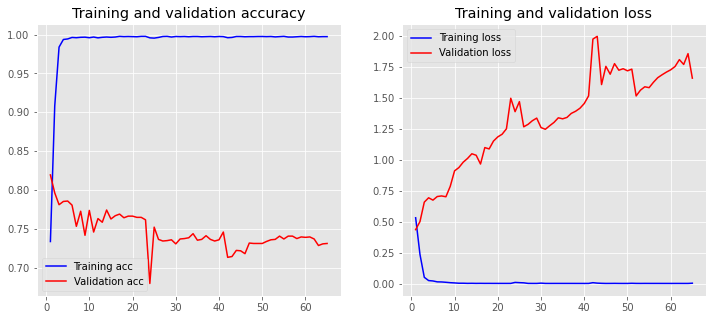

In [50]:
plot_history(history)

**Looks like optimum training point is about epoch 4 - let's retrain to that**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 160, 100)          1865200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 156, 64)           32064     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,914,161
Trainable params: 1,914,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
357/357 [==============================] - 7s 18ms/step - loss: 0.6133 - accuracy: 0.6478 - val_loss

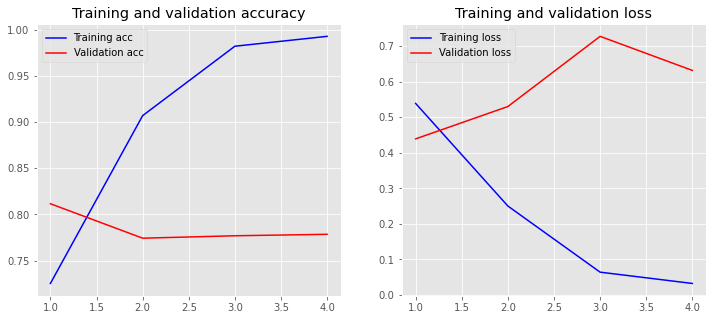

In [53]:
model = get_model()
history = model.fit(
    X_train_vect, y_train, epochs=4, verbose=1, 
    validation_data=(X_test_vect, y_test), batch_size=16,
    callbacks=[es]
)
plot_history(history)

**Looks like our best ~80% accuracy might be the ceiling here. Our XGBoost and SVC performed roughly the same - let's pick the SVC for now as it performs ever slightly better. Let's finally predict on our validation test set and upload to Kaggle!**

In [54]:
val_proc = preprocess_df(val, train=False)

In [55]:
val_proc

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,chars,words,contains_url
0,-0.050505,0.308120,-0.148096,0.162880,0.131526,-0.161931,0.004152,-0.226200,-0.011638,2.471017,...,-0.192910,0.180882,-0.074780,-0.081589,-0.008182,0.119096,0.065696,34,6,0
2,-0.025757,0.292128,-0.184004,-0.196917,0.096486,0.004632,0.019400,-0.051837,-0.049367,2.251637,...,0.014848,0.083322,0.023566,-0.157935,0.016531,-0.119426,0.133548,64,9,0
3,0.012182,0.129268,-0.190941,-0.102834,0.105830,0.064567,-0.001545,-0.044771,-0.189545,2.306918,...,-0.104431,-0.133592,0.088430,-0.123709,-0.036356,-0.015761,0.076801,96,19,0
9,-0.173604,0.159634,0.216364,-0.218809,-0.024715,-0.089679,0.172309,0.206739,-0.137449,0.853369,...,0.204457,0.004870,-0.161439,-0.134559,-0.082690,-0.293732,0.069293,40,4,0
11,-0.175291,0.322388,0.125275,-0.133462,0.154615,-0.016825,0.019487,-0.009099,0.094916,1.037178,...,0.093558,-0.129959,-0.115040,-0.169215,0.065764,-0.231117,0.332777,45,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10861,0.051009,0.053705,0.092849,0.032585,0.130665,-0.266425,-0.048828,0.036363,-0.023070,1.010845,...,0.118493,0.330770,-0.096660,0.093989,0.005320,0.026829,0.068863,55,8,0
10865,-0.043876,0.168761,-0.049294,-0.119383,0.119087,-0.026727,0.005873,0.003380,-0.015345,1.911376,...,0.010217,0.000878,0.041666,-0.069259,0.056738,-0.093649,0.028527,139,23,0
10868,0.045179,0.161062,0.056522,-0.119962,0.504487,0.212347,-0.031283,-0.008410,-0.012093,1.223308,...,-0.139120,-0.081405,-0.074482,-0.104706,0.071525,-0.140237,0.290040,55,6,0
10874,-0.046740,0.116137,-0.043217,0.041952,-0.120096,0.097775,0.095649,-0.145780,0.060794,1.058670,...,-0.004398,-0.043952,0.003886,-0.086006,-0.185807,-0.028134,-0.138579,65,7,0


In [77]:
y_val = clf.predict(val_proc)

In [93]:
results = pd.DataFrame(y_val, index=val.index, columns=["target"])
results["target"] = results.target.astype("int64")
results

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [95]:
results.to_csv("~/results.csv")

**For future iterations, maybe we perform feature engineering, further tune the CNN, or add additional convolutional or dense layers, or use transformers (e.g. BERT) for text vectorization**